In [1]:
!pip install image_classifiers
#!pip install keras==3.1.1 tensorflow==2.16.1
import numpy as np
import tensorflow as tf
import keras
from keras.applications import ResNet50V2
from keras.datasets import cifar100
from keras import Sequential, Input
from keras.layers import Dense, Dropout, RandomFlip, RandomTranslation, RandomRotation,RandomBrightness, RandomContrast, RandomZoom, GlobalAveragePooling2D
from keras.applications.resnet_v2 import preprocess_input
from keras.models import Model
from classification_models.keras import Classifiers
from keras.optimizers import SGD,Adam
from keras.activations import linear
from keras.utils import Progbar
from keras.backend import clear_session
from tensorflow.nn import softmax_cross_entropy_with_logits
import os
import re
import functools

2024-05-12 11:11:12.326939: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 11:11:12.409489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 11:11:13.532208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
n_epoch = 10 # Sur chaque split glissant (21 splits glissants, chaque donnée sauf aux extrêmités réapparait 5 fois)
batch_size = 64
taux_validation = 0.1
num_classes = 100
n_images = 50000

In [3]:
validation_size = int(n_images * taux_validation)
train_size = n_images - validation_size

In [4]:
model_enseignant = Sequential([
    Input((224,224,3)),
    ResNet50V2(include_top=False, weights='imagenet', pooling="avg"),
    Dropout(0.25),
    Dense(256, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.L1(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.001))
])
for layer in model_enseignant.layers:
    if layer.name == "resnet50v2":
        for layer in layer.layers[:]:
          if (re.match("^.*(_3_conv|_bn)$", layer.name)):
            layer.trainable = True
          else:
            layer.trainable = False

2024-05-12 11:11:14.898089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13290 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:18:00.0, compute capability: 8.6


In [5]:
def preprocessing(image, label):
    image = tf.image.resize(image, (224, 224))
    label = tf.squeeze(tf.one_hot(label, depth = num_classes), axis = 0)
    return  image, label

augmentation_donnees_keras = Sequential([
    RandomFlip("horizontal"),
    RandomTranslation(0.2,0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2,value_range=(0,1))
])

def augmentation_donnees(image, label):
    return augmentation_donnees_keras(image/255.0, training = True)*255.0, label

def preprocess_resnet(image, label):
    return preprocess_input(image), label

def train_val_split(train_dataset):
    X_train, y_train = train_dataset
    return (X_train[:train_size,...], y_train[:train_size,...]), (X_train[train_size:,...], y_train[train_size:,...])

def make_train_val(train_dataset):
    train_dataset, validation_dataset = train_val_split(train_dataset)
    return train_dataset, validation_dataset

def vers_dataset_train(train, split_size):
    train_dataset = tf.data.Dataset.from_tensor_slices(train).map(preprocessing).cache().repeat().shuffle(split_size).batch(batch_size).map(augmentation_donnees, num_parallel_calls = tf.data.AUTOTUNE).map(preprocess_resnet, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_dataset

def vers_dataset_val(val):
    validation_dataset = tf.data.Dataset.from_tensor_slices(val).map(preprocessing).batch(batch_size).map(preprocess_resnet).cache().prefetch(tf.data.AUTOTUNE)
    return validation_dataset

def faire_splits_glissants(array, n = 25):
    nsqrt = int(np.sqrt(n))
    splits = np.split(array, n)
    splits = [np.vstack(splits[i:i+nsqrt]) for i in range(n - nsqrt + 1)]
    return splits

def load_cifar_train_splits_val():
    train, _ = cifar100.load_data()
    train, val = make_train_val(train)
    train_splits = list(zip(*map(faire_splits_glissants, train)))
    return train_splits, val

In [6]:
def get_modele_logits(modele):
    config = modele.layers[-1].get_config()
    config['activation'] = linear
    config['name'] = 'logits'
    res = Model(inputs=modele.inputs, outputs=[Dense(**config)(modele.layers[-2].output)])
    res.layers[-1].set_weights([x.numpy() for x in modele.layers[-1].weights])
    res.compile(metrics=['accuracy'])
    return res

def get_regularisation(model):
    return [(getattr(layer,reg),layer.kernel) for layer in model.layers for reg in ["kernel_regularizer", "bias_regularizer"] if hasattr(layer, reg) and getattr(layer,reg) is not None]

@tf.function
def perte_regularisation(regularisation):
    return tf.add_n([tf.reduce_sum(reg(kernel)) for reg, kernel in regularisation])

@tf.function
def compte_bons(x,y):
    return tf.reduce_sum(tf.cast(tf.equal(tf.argmax(x, axis = 1), tf.argmax(y, axis = 1)), tf.float32))

@tf.function
def softmax(logits, temp):
    expo = tf.exp(logits / temp)
    return expo / tf.reduce_sum(expo, axis = 1, keepdims=True)

@tf.function
def ce(x, y_logits, temp):
    return softmax_cross_entropy_with_logits(x, y_logits / temp) * temp**2

def init_csv_log(fichier):
    with open(fichier,'w') as file:
        file.write("split, epoch, accuracy_etu, accuracy_ens, accuracy_dis, val_accuracy_etu, val_accuracy_ens, val_accuracy_dis\n")
def append_csv_log(fichier, split, epoch, accuracy_etu, accuracy_ens, accuracy_dis, val_accuracy_etu, val_accuracy_ens, val_accuracy_dis):
    with open(fichier,'a') as file:
        file.write(f"{split:d},{epoch:d},{accuracy_etu:.2f},{accuracy_ens:.2f},{accuracy_dis:.2f},{val_accuracy_etu:.2f},{val_accuracy_ens:.2f},{val_accuracy_dis:.2f}\n")

def forward_backward_pass_impl(train_dataset_iter, enseignant_logit_model, etudiant_logit_model, alpha, temp, optim_etudiant, optim_enseignant, regularisation_etudiant, regularisation_enseignant):
    X_batch, y_batch = next(train_dataset_iter)
    with tf.GradientTape() as tape_ens:
        enseignant_estim_logit = enseignant_logit_model(X_batch, training = True)
        perte_ens = softmax_cross_entropy_with_logits(y_batch,enseignant_estim_logit) + perte_regularisation(regularisation_enseignant)
    enseignant_estim_softmax = softmax(enseignant_estim_logit, temp)
    with tf.GradientTape() as tape_etu:
        etudiant_estim_logit = etudiant_logit_model(X_batch, training = True)
        perte_etu = alpha * softmax_cross_entropy_with_logits(y_batch,etudiant_estim_logit) + (1-alpha) * ce(enseignant_estim_softmax,etudiant_estim_logit, temp) + perte_regularisation(regularisation_etudiant)
    grad_etudiant = tape_etu.gradient(perte_etu, etudiant_logit_model.trainable_variables)
    grad_enseignant = tape_ens.gradient(perte_ens, enseignant_logit_model.trainable_variables)
    optim_etudiant.apply_gradients(zip(grad_etudiant, etudiant_logit_model.trainable_variables))
    optim_enseignant.apply_gradients(zip(grad_enseignant, enseignant_logit_model.trainable_variables))
    return compte_bons(etudiant_estim_logit,y_batch), compte_bons(enseignant_estim_logit,y_batch), compte_bons(etudiant_estim_logit,enseignant_estim_logit)

@tf.function
def val_accuracies(etudiant, enseignant, validation_dataset):
    val_bons_etu, val_bons_ens, val_bons_dis = 0.0, 0.0, 0.0
    for X_batch, y_batch in validation_dataset:
        etu_prev = etudiant(X_batch, training = False)
        ens_prev = enseignant(X_batch, training = False)
        val_bons_etu += compte_bons(etu_prev, y_batch)
        val_bons_ens += compte_bons(ens_prev, y_batch)
        val_bons_dis += compte_bons(etu_prev, ens_prev)
    nb_obs_val = tf.cast((validation_size//batch_size) * batch_size, tf.float32)
    val_accuracy_etu = val_bons_etu / nb_obs_val
    val_accuracy_ens = val_bons_ens / nb_obs_val
    val_accuracy_dis = val_bons_dis / nb_obs_val
    return val_accuracy_etu, val_accuracy_ens, val_accuracy_dis

def distillateur_kl_en_ligne(etudiant, enseignant, train_dataset, validation_dataset, temp, nom_modele, n_epoch, alpha, num_split, split_size):
    etudiant_logit_model = get_modele_logits(etudiant)
    enseignant_logit_model = get_modele_logits(enseignant)
    optim_etudiant = SGD(learning_rate=0.001)
    optim_enseignant = Adam(learning_rate=0.0001)
    print(f"~~~~~ Distillation split n°{num_split + 1} ~~~~~~")
    val_accuracy_etu_max, val_accuracy_ens_max, val_accuracy_dis_max  = 0, 0, 0
    regularisation_etudiant = get_regularisation(etudiant)
    regularisation_enseignant = get_regularisation(enseignant)
    train_dataset_iter = iter(train_dataset)
    if num_split <= 4:
        alpha, temp = 1, 1
    # Pour les premiers splits on ne distille pas.
    forward_backward_pass = tf.function(forward_backward_pass_impl)
    # La tf.function ne peut être que locale car son graphe dépend d'étudiant_logit_model et sinon Tensorflow renvoie une erreur à deux applications successives
    for epoch in range(n_epoch):
        print(f"Époque {epoch + 1} / {n_epoch}")
        n_batch = split_size//batch_size
        barre_progression = Progbar(n_batch, stateful_metrics = ["acc (etu, train)", "acc (ens, train)", "acc (dis, train)"])
        bons_epoque_etu, bons_epoque_ens, bons_epoque_dis = 0, 0, 0
        for i in range(n_batch):
            bons_etu, bons_ens, bons_dis = forward_backward_pass(train_dataset_iter, enseignant_logit_model, etudiant_logit_model, alpha, temp, optim_etudiant, optim_enseignant, regularisation_etudiant, regularisation_enseignant)
            bons_epoque_etu += bons_etu.numpy()
            bons_epoque_ens += bons_ens.numpy()
            bons_epoque_dis += bons_dis.numpy()
            n_observ = (i+1) * batch_size
            accuracy_etu, accuracy_ens, accuracy_dis = bons_epoque_etu / n_observ, bons_epoque_ens / n_observ, bons_epoque_dis / n_observ
            barre_progression.update(i + 1, values = [("acc (etu, train)", accuracy_etu), ("acc (ens, train)", accuracy_ens), ("acc (dis, train)", accuracy_dis)])
        val_accuracy_etu, val_accuracy_ens, val_accuracy_dis = val_accuracies(etudiant, enseignant, validation_dataset)
        if epoch + 1 == 10:
            optim_etudiant.learning_rate.assign(0.0001)
        append_csv_log(f"sauvegardes/{nom_modele}_logs.csv", num_split, epoch, accuracy_etu, accuracy_ens, accuracy_dis, val_accuracy_etu, val_accuracy_ens, val_accuracy_dis)
        print(f"Accuracy (etu, val) : {val_accuracy_etu:.4f} | Accuracy (ens, val) : {val_accuracy_ens:.4f} | Accuracy (dis, val) : {val_accuracy_dis:.4f}")

In [7]:
def distillation_resnet18_en_ligne(temp, alpha):
    clear_session()
    train_splits, val = load_cifar_train_splits_val()
    modele = new_modele_resnet()
    nom_modele =  f"model_etudiant_ligne_t{temp:d}"
    init_csv_log(f"sauvegardes/{nom_modele}_logs.csv")
    validation_dataset = vers_dataset_val(val)
    for num_split, train in enumerate(train_splits):
        split_size = train[0].shape[0]
        train_dataset = vers_dataset_train(train, split_size)
        distillateur_kl_en_ligne(modele, model_enseignant, train_dataset, validation_dataset, temp, nom_modele, n_epoch, alpha, num_split, split_size)
    wd = os.getcwd()
    os.system(f"mc cp {wd}/sauvegardes/{nom_modele}_logs.csv s3/afeldmann/projet_cnam/{nom_modele}_logs.csv")

In [8]:
def ResNet18():
    resnet18, preprocess_input = Classifiers.get('resnet18')
    resnet = resnet18((224, 224, 3), weights='imagenet', include_top=False)
    resnet_output = GlobalAveragePooling2D()(resnet.output)
    resnet = Model(inputs=resnet.input, outputs=resnet_output)
    return resnet

def new_modele_resnet():
    model = Sequential([
        Input((224,224,3)),
        ResNet18(),
        Dropout(0.25),
        Dense(256, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.L1(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.001))
    ])
    model.compile(metrics=['accuracy'])
    return model

In [9]:
wd = os.getcwd()
os.system(f"mkdir -p {wd}/sauvegardes")
distillation_resnet18_en_ligne(3, 0.5)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
~~~~~ Distillation split n°1 ~~~~~~
Époque 1 / 10


2024-05-12 11:11:54.151760: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


140/140 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - acc (etu, train): 0.0234 - acc (ens, train): 0.0228 - acc (dis, train): 0.0090
Accuracy (etu, val) : 0.0090 | Accuracy (ens, val) : 0.1304 | Accuracy (dis, val) : 0.0002
Époque 2 / 10
140/140 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc (etu, train): 0.0635 - acc (ens, train): 0.1022 - acc (dis, train): 0.0459
Accuracy (etu, val) : 0.0096 | Accuracy (ens, val) : 0.2812 | Accuracy (dis, val) : 0.0226
Époque 3 / 10
140/140 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc (etu, train): 0.1122 - acc (ens, train): 0.2124 - acc (dis, train): 0.1010
Accuracy (etu, val) : 0.0100 | Accuracy (ens, val) : 0.3648 | Accuracy (dis, val) : 0.0182
Époque 4 / 10
140/140 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc (etu, train): 0.1541 - acc (ens, train): 0.2897 - acc (dis, train): 0.1531
Accuracy (etu, val) : 0.0317 | Accuracy (ens, val) : 0.4451 | Accuracy (dis, val) : 0.0459
Époque 5 / 10
140/140 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc (etu, train): 0.1989 - acc (ens, train):

cp: cannot stat '/home/onyxia/work/projet_distillation_cnam/sauvegardes/model_etudiant_ligne_t3_checkpoint.keras': No such file or directory


`/home/onyxia/work/projet_distillation_cnam/sauvegardes/model_etudiant_ligne_t3_logs.csv` -> `s3/afeldmann/projet_cnam/model_etudiant_ligne_t3_logs.csv`
Total: 7.19 KiB, Transferred: 7.19 KiB, Speed: 74.76 KiB/s


mc: <ERROR> Unable to prepare URL for copying. Unable to guess the type of copy operation.


In [10]:
model_enseignant.save("/home/onyxia/work/projet_distillation_cnam/sauvegardes/model_etudiant_ligne_t3.keras")
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/model_etudiant_ligne_t3.keras s3/afeldmann/projet_cnam/model_etudiant_ligne_t3.keras

...e_t3.keras: 92.59 MiB / 92.59 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 62.76 MiB/s 1s

In [11]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 46.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 5.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 34.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 14.0 MB/s eta 0:00:00


In [12]:
import matplotlib.pyplot as plt

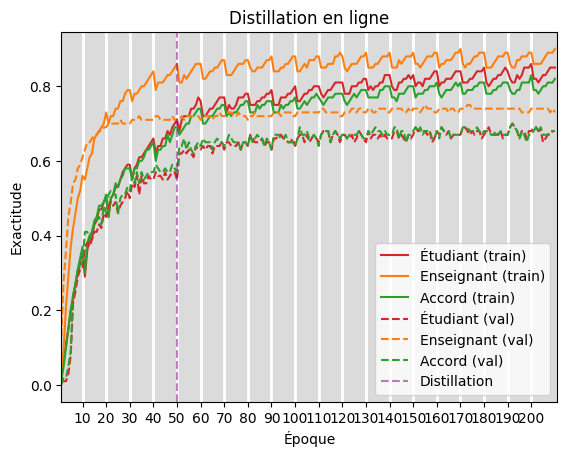

In [13]:
c = ["tab:red", "tab:orange", "tab:green"]
history=np.genfromtxt("sauvegardes/model_etudiant_ligne_t3_logs.csv", delimiter=",", names = True)
l = np.arange(history.shape[0]) + 1
plt.plot(l, history['accuracy_etu'], c = c[0])
plt.plot(l, history['accuracy_ens'], c = c[1])
plt.plot(l, history['accuracy_dis'], c = c[2])
plt.plot(l, history['val_accuracy_etu'], linestyle='dashed', c = c[0])
plt.plot(l, history['val_accuracy_ens'], linestyle='dashed', c = c[1])
plt.plot(l, history['val_accuracy_dis'], linestyle='dashed', c = c[2])
plt.axvline(x=50, color='purple', ls='--', label='Limite réglage fin', alpha = 0.5)
plt.title('Distillation en ligne')
plt.ylabel('Exactitude')
plt.xlabel('Époque')
plt.legend(["Étudiant (train)", "Enseignant (train)", "Accord (train)",
           "Étudiant (val)", "Enseignant (val)", "Accord (val)", "Distillation"], loc='best')
plt.gca().set_xticks(np.where(history['split'][:-1] != history['split'][1:])[0] + 1)
plt.gca().set_xlim(left = l[0], right = l[-1] + 1)
plt.grid(True, color='w', linestyle='-', linewidth=2, axis = "x")
plt.gca().patch.set_facecolor('0.8')
plt.gca().patch.set_alpha(0.7)
plt.show()